In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import pyproj
from rasterio.transform import Affine

import dask.dataframe as dd
import matplotlib.pyplot as plt
import matplotlib.colors as cl

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

from xgcm import Grid
from xhistogram.xarray import histogram
import warnings
warnings.filterwarnings("ignore")

import os
from glob import glob

import histlib.box as box
import histlib.aviso as aviso
import histlib.cstes as cstes
import histlib.diagnosis as diag
from histlib.diagnosis import put_fig_letter
from histlib.cstes import labels, zarr_dir, matchup_dir, U
U2 = U**2

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=5, processes=5, walltime='02:00:00')
    w = cluster.scale(jobs=4)
    #w = cluster.scale(jobs=3)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.251:8787/status,
Dashboard: http://10.148.0.251:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.251:43715,Workers: 0
Dashboard: http://10.148.0.251:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# Create csv files

In [6]:
zarrs_cutoff = sorted(glob(os.path.join('/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/cutoff_matchup', '*_2.zarr')))

In [7]:
zarrs = sorted(glob(os.path.join('/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/matchup', '*')))

In [8]:
for i in range(len(zarrs)) :
    ds0 = xr.open_dataset(zarrs_cutoff[i])[['drifter_acc_x_25','drifter_coriolis_x_25']]
    ds1 = xr.open_dataset(zarrs[i])[['drogue_status','drifter_acc_x_0','drifter_coriolis_x_0','alti_ggx_adt_filtered_ocean_tide_internal_tide', 'aviso_alti_ggx_adt', 'aviso_drifter_ggx_adt', 'es_cstrio_z15_drifter_wd_x', 'es_cstrio_z15_alti_wd_x']]
    path = os.path.join('/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err', zarrs[i].split('/')[-1].replace('zarr', 'csv'))
    df = xr.merge([ds0, ds1]).to_dataframe()
    df.where(df.drogue_status).dropna().to_csv(path)#only drogued drifters
    print(path)

/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2010.csv
/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2011.csv
/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2012.csv
/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2013.csv
/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2014.csv
/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2015.csv
/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2016.csv
/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2017.csv
/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2018.csv
/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err/matchup_argos_Cryosat-2_2019.csv


# Preparation

In [6]:
zarrs = glob(os.path.join('/home/datawork-lops-oc/aponte/margot/historical_coloc_ok/coloc_err', '*'))

In [7]:
df = dd.concat([pd.read_csv(z) for z in zarrs])

In [8]:
df = df.compute()

In [9]:
len(df)

1896241

In [41]:
dl = 5000
df["distbin"] = (df.alti___distance // dl) * dl/1000

In [42]:
df = df.rename(columns = {'aviso_alti_ggx_adt':'ggx', 
          'aviso_drifter_ggx_adt':'ggxd', 
           'drifter_acc_x_25':'acc',
           'drifter_coriolis_x_25':'cor',
           'es_cstrio_z15_drifter_wd_x':'wd',
          })[['obs','acc','cor','drogue_status','ggx','ggxd','wd','alti___distance','alti___time_difference','lat','lon','time','distbin']]

In [43]:
df['da'] = (df.ggx - df.ggxd)#ggx diff
df['sd']  = df.acc + df.cor + df.ggxd + df.wd #s (no coloc error)
df['s']  = df.acc + df.cor + df.ggx + df.wd #s* with colocation error

var = ['acc', 'cor', 'ggx', 'wd']
vard = ['acc', 'cor', 'ggxd', 'wd']

# Correlation with ggx diff
for v in var : 
    df[v+'da'] = df.da*df[v]
df['ggxdda'] = df.da*df.ggxd

df['sda'] = df['da']*df['s']
df['sdda'] = df['da']*df['sd']

df2 = df[[v for v in df if v not in['obs','drogue_status','alti___distance','alti___time_difference','lat','lon','time','distbin' ]]]**2 # mean square values
df2['distbin'] =df['distbin']

In [44]:
df_ = df.where(df.alti___distance<25000).dropna()
df2_ = df2.where(df.alti___distance<25000).dropna()
print(len(df_))

238662


_________
# Distribution on DL

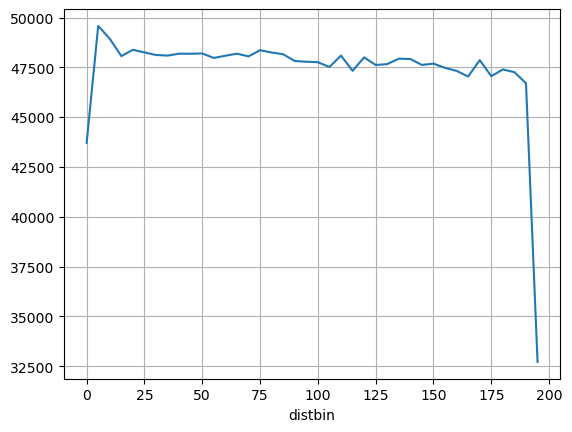

In [45]:
count = df.groupby("distbin").ggx.count()
count.plot()
plt.grid()

____________
___________

# Notations

On reconstruit l'équation du moment avec 4 termes : 
$$ a_1 + a_2 +a_3 +a_4 = s $$
Le résidu $s$ rassemble toutes les erreurs liées à la reconstruction, et peut-être divisée en trois erreurs : 
$$s = o$$
- $c$ erreur de colocalisation liée au fait que le terme de gradient n'est pas estimé à la même position
- $o$ les autres erreurs

Les lettres majuscules désignent la moyenne du carré sur l'ensemble des colocalisations des valeurs associées

____________
____________

# Introducing colocalizations errors on the pressure gradient term $a_3$ :

- Equilibre sans erreur de colocalisation : $a_1 + a_2 +a_3 +a_4 = o = s $
  
- Equilibre reconstruit, avec erreur de colocalisation : $a_1 + a_2 +a^*_3 +a_4 = c + o^* = s^* $

Et en notant $(a^*_3 - a_3) = d_3$
$$ c = a^*_3 - a_3 + o^* - o = d_3 + o^* - o$$


$$ S^* - S = \langle (c+o)^2 \rangle - O = d_3 + 2\langle d_3 o \rangle $$
avec $\langle d_3 o^* \rangle$ petit devant $d_3$ et $O$ : 
$\langle d_3 o \rangle/d_3 = -16.1\%$ pour DL<25km 
$\langle d_3 o \rangle/S = -2\%$ pour DL<25km 

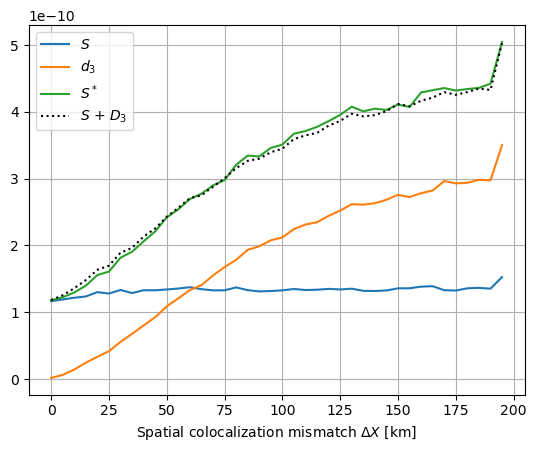

In [46]:
df2['sd2_da2']=df2.sd+df2.da
df2.groupby("distbin").sd.mean().plot(label = r'$S$')
df2.groupby("distbin").da.mean().plot(label = r'$d_3$')
df2.groupby("distbin").s.mean().plot(label = r'$S^*$')
df2.groupby("distbin").sd2_da2.mean().plot(label = r'$S$ + $D_3$', c='k', ls=':')
plt.xlabel('Spatial colocalization mismatch $\Delta X$ [km]')
plt.legend()
plt.grid()

In [47]:
2*df_['sdda'].mean()/df2_['da'].mean()

-0.3213117880609465

In [48]:
df_['sdda'].mean()/df2_['sd'].mean()

-0.02134367357869633

____________
____________
# Décomposition des différents termes 
## Comparaison des $\beta_{i}$ en fonction des $B_i$

- Pour $i\neq3$, par exemple i=1:
$ \beta^*_i - \beta_i = -\langle a_i a_2 \rangle - \langle a_i a_3 \rangle -\langle a_i a_4 \rangle +\langle a_i a_2 \rangle +\langle a_i a^*_3 \rangle + \langle a_i a_4 \rangle = -\langle a_i d_3 \rangle $

- Pour $i=3$:
$ \beta ^*_3- \beta_3= -\sum_{j\neq 3}\langle a_j d_3 \rangle $

Vérifié sur le plot ci-dessous 

$$ \sum_i (\beta^*_i - \beta_i) = -2\sum_{j\neq 3}\langle a_j d_3 \rangle$$

## Lien $\beta^*_i$ à $B_i$?

  - Pour $i\neq3$, par exemple i=1 on a :
         $ \beta^*_i = B_i -\langle a_i d_3 \rangle = B_i -\langle b_i d_3 \rangle -\langle o_i d_3 \rangle$
  - Pour $i=3$:
        $ \beta_3  = B_3 -\sum_{j\neq 3}\langle a_j d_3 \rangle $
La vraie partie équilibrée du signal est donc cachée sous $\langle a_i d_3 \rangle$ ou $-\sum_{j\neq i}\langle a_j d_3 \rangle$ 

In [49]:
from itertools import combinations
comb = list(combinations(var, 2))
combd = list(combinations(vard, 2))
for c in comb :
    df[f'{c[0]}_{c[1]}'] = df[c[0]]*df[c[1]]
for c in combd :
    df[f'{c[0]}_{c[1]}'] = df[c[0]]*df[c[1]]

In [50]:
for v in var :
    df['b_'+v] = -df[[f'{c[0]}_{c[1]}' for c in comb if v in f'{c[0]}_{c[1]}']].sum(axis=1)

for v in vard :
    df['bd_'+v] = -df[[f'{c[0]}_{c[1]}' for c in combd if v in f'{c[0]}_{c[1]}']].sum(axis=1)

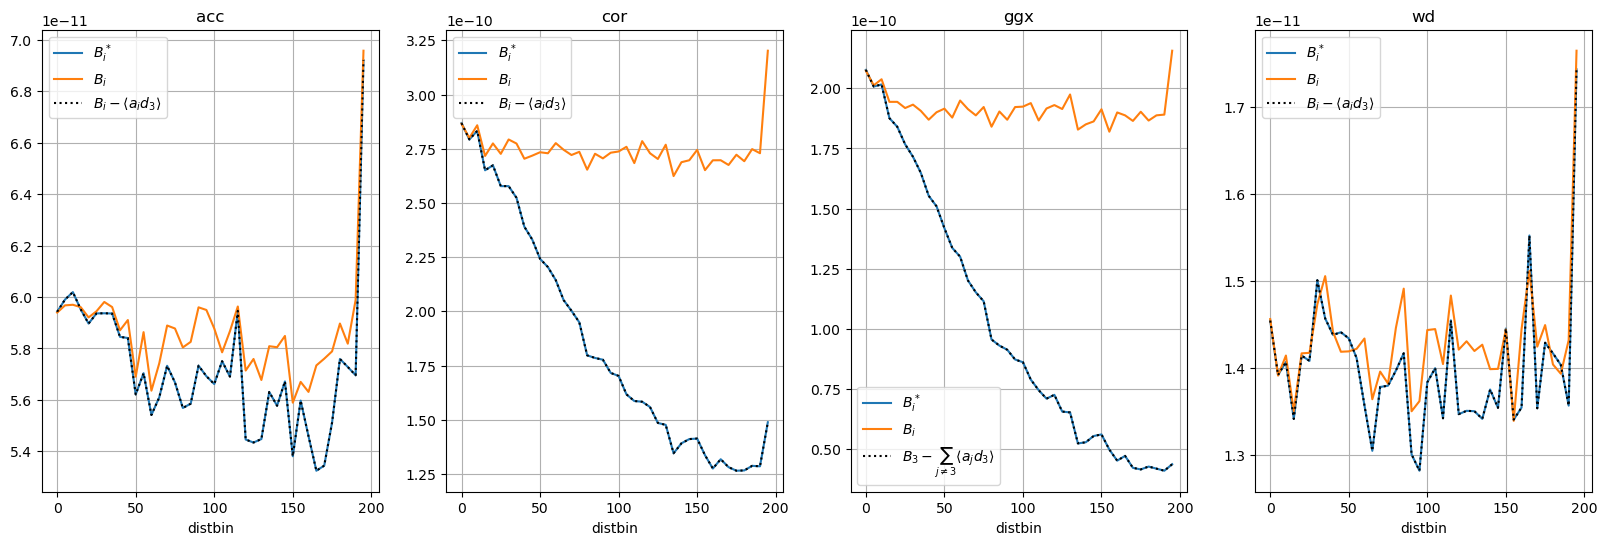

In [52]:
fig, axs = plt.subplots(1, 4,figsize=(20,6))
axs = axs.flatten()
for i in range(len(var)):
    ax = axs[i]
    v, vd = var[i], vard[i]
    df.groupby("distbin")['b_'+v].mean().plot(label=r'$B^*_i$', ax=ax)
    df.groupby("distbin")['bd_'+vd].mean().plot(label=r'$B_i$', ax=ax)
    if v != 'ggx':
        (-df.groupby("distbin")[v+'da'].mean() + df.groupby("distbin")['bd_'+vd].mean()).plot(label=r'$B_i - \langle a_i d_3 \rangle$', ax=ax, c='k', ls=':')
    else:
        (-df.groupby("distbin")[[u+'da' for u in var if u!='ggx']].mean().sum(axis=1)+ df.groupby("distbin")['bd_'+vd].mean()).plot(label=r'$B_3 - \sum_{j\neq 3}\langle a_j d_3 \rangle$', ax=ax, c='k', ls=':')
    #(df.groupby("distbin")[vd+'e'].mean() + df.groupby("distbin")['bd_'+vd].mean()).plot(label=r'$B_i + \langle a_i e \rangle$', ax=ax, c='b', ls=':')
    ax.grid()
    ax.set_title(v)
    ax.legend()

## Comparaison des $\epsilon_{i}$ en fonction des $E_i$

- Pour $i\neq3$, par exemple i=1:
$ \epsilon^*_i - \epsilon_i = \langle a_i d_3 \rangle $

- Pour $i=3$:
$ \epsilon^*_3 - \epsilon_3 = \langle a^*_3s^* \rangle - \langle a_3 s \rangle = \langle d_3\sum_{j\neq3} a_j\rangle + A^*_3 -A_3$

- Nous avons bien : $S^* = \sum_i \epsilon^*_i = d_3 + O + 2\langle d_3 o \rangle$
  avec $2\langle d_3 o^* \rangle$ petit devant $d_3$ (voir ci-dessus)

In [62]:
for v in var :
    df[v+'s'] =  df[v] * df['s']
    df2[v+'s'] = df[v+'s']

for v in vard :
    df[v+'sd'] =  df[v] * df['sd']
    df2[v+'sd'] = df[v+'sd']

df['sumb'] = df[['b_'+v for v in var]].sum(axis=1)
df['sumbd'] = df[['bd_'+v for v in vard]].sum(axis=1)
df['sume'] = df[[v+'s' for v in var]].sum(axis=1)
df['sumed'] = df[[v+'sd' for v in vard]].sum(axis=1)

df_ = df.where(df.alti___distance<25).dropna()
df2_ = df2.where(df.alti___distance<25).dropna()

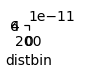

In [79]:
#
fig, ax = plt.subplots(1, 1,figsize=(0,0), sharex=True)
v, vd = var[0], vard[0]
df.groupby("distbin")[v+'s'].mean().plot(label=r'$\epsilon^*_i$ - AVISO altimeter matchup', ax=ax, c='b')
df.groupby("distbin")[vd+'sd'].mean().plot(label=r'$\epsilon_i$ - AVISO drifter matchup', ax=ax, c='g')
df.groupby("distbin")['b_'+v].mean().plot(label=r'$\beta^*_i$ - AVISO altimeter matchup', ax=ax, c='r')
df.groupby("distbin")['bd_'+vd].mean().plot(label=r'$\beta_i$ - AVISO drifter matchup', ax=ax, c='orange')
handlest, labelst = ax.get_legend_handles_labels()
 

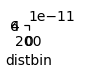

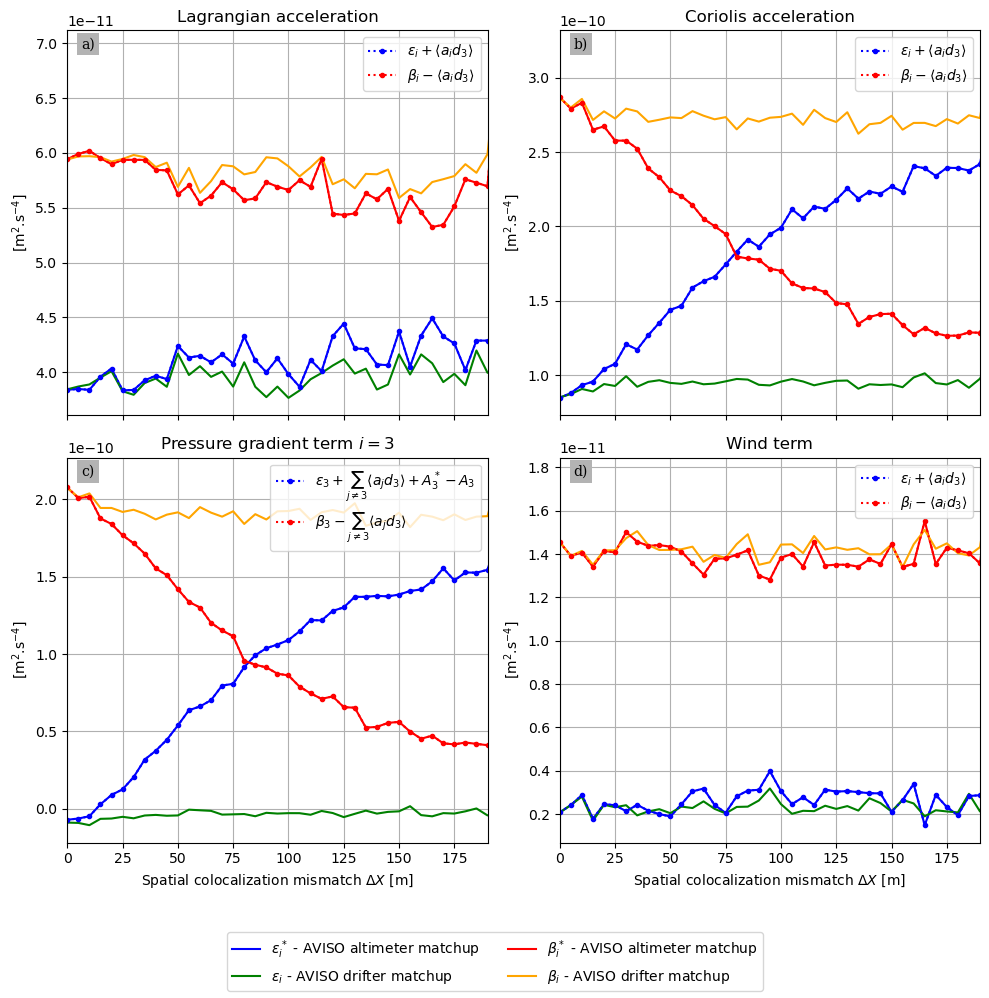

In [96]:
# get fig labels
fig, ax = plt.subplots(1, 1,figsize=(0,0), sharex=True)
v, vd = var[0], vard[0]
df.groupby("distbin")[v+'s'].mean().plot(label=r'$\epsilon^*_i$ - AVISO altimeter matchup', ax=ax, c='b')
df.groupby("distbin")[vd+'sd'].mean().plot(label=r'$\epsilon_i$ - AVISO drifter matchup', ax=ax, c='g')
df.groupby("distbin")['b_'+v].mean().plot(label=r'$\beta^*_i$ - AVISO altimeter matchup', ax=ax, c='r')
df.groupby("distbin")['bd_'+vd].mean().plot(label=r'$\beta_i$ - AVISO drifter matchup', ax=ax, c='orange')
handlest, labelst = ax.get_legend_handles_labels()

#
fig, axs = plt.subplots(2, 2,figsize=(10,10), sharex=True)
axs = axs.flatten()
Titles = [r'Lagrangian acceleration', r'Coriolis acceleration', r'Pressure gradient term $i=3$', r'Wind term']
letters = ['a', 'b', 'c', 'd']
for i in range(len(var)):
    ax = axs[i]
    v, vd = var[i], vard[i]
    if v!= 'ggx':
        df.groupby("distbin")[v+'s'].mean().plot(ax=ax, c='b')
        df.groupby("distbin")[vd+'sd'].mean().plot(ax=ax, c='g')
        (df.groupby("distbin")[v+'da'].mean() + df.groupby("distbin")[vd+'sd'].mean()).plot(label=r'$\epsilon_i + \langle a_i d_3 \rangle$', ax=ax, c='b', ls=':', marker ='.')
    else:
        df.groupby("distbin")[v+'s'].mean().plot(ax=ax, c='b')
        df.groupby("distbin")[vd+'sd'].mean().plot(ax=ax, c='g')
        (df.groupby("distbin")[[u+'da' for u in var if u!='ggx']].mean().sum(axis=1) + df2.groupby("distbin")['ggx'].mean() - df2.groupby("distbin")['ggxd'].mean() + df.groupby("distbin")[vd+'sd'].mean()).plot(label=r"$\epsilon_3 + \sum_{j\neq3} \langle a_j d_3 \rangle + A^*_3 - A_3 $", ax=ax, c='b', ls=':', marker ='.')
         #(df.groupby("distbin")[[u+'da' for u in var if u!='ggx']].mean().sum(axis=1)  + df.groupby("distbin")[vd+'sd'].mean()).plot(label=r"$E_{3eq} + \langle d_3\sum_{j\neq3} a_j) + a'^2_3 -a^2_3 \rangle$", ax=ax, c='g', ls=':')
    ax.grid()
    
for i in range(len(var)):
    ax = axs[i]
    v, vd = var[i], vard[i]
    df.groupby("distbin")['b_'+v].mean().plot(c='r', ax=ax)
    df.groupby("distbin")['bd_'+vd].mean().plot(c='orange', ax=ax)
    if v != 'ggx':
        (-df.groupby("distbin")[v+'da'].mean() + df.groupby("distbin")['bd_'+vd].mean()).plot(label=r'$\beta_i - \langle a_i d_3 \rangle$', ax=ax, c='r', ls=':', marker ='.')
    else:
        (-df.groupby("distbin")[[u+'da' for u in var if u!='ggx']].mean().sum(axis=1)+ df.groupby("distbin")['bd_'+vd].mean()).plot(label=r'$\beta_3 - \sum_{j\neq 3}\langle a_j d_3 \rangle$', ax=ax, c='r', ls=':', marker ='.')
    #(df.groupby("distbin")[vd+'e'].mean() + df.groupby("distbin")['bd_'+vd].mean()).plot(label=r'$B_i + \langle a_i e \rangle$', ax=ax, c='b', ls=':')
    ax.grid()
    ax.set_title(Titles[i])
    ax.legend(ncol = 2)
    ax.set_xlabel('Spatial colocalization mismatch $\Delta X$ [m]')
    ax.set_xlim(0, 190)
    ax.set_ylabel(r'[m$^2$.s$^{-4}$]')
    put_fig_letter(fig, ax, letters[i])
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[slice(2,6,3)],labels[slice(2,6,3)])
    
fig.legend(handlest, labelst, ncols=2,loc='lower center')
fig.tight_layout(rect=[0,0.09,1,1])#left, bottom, right, top (default is 0,0,1,1)


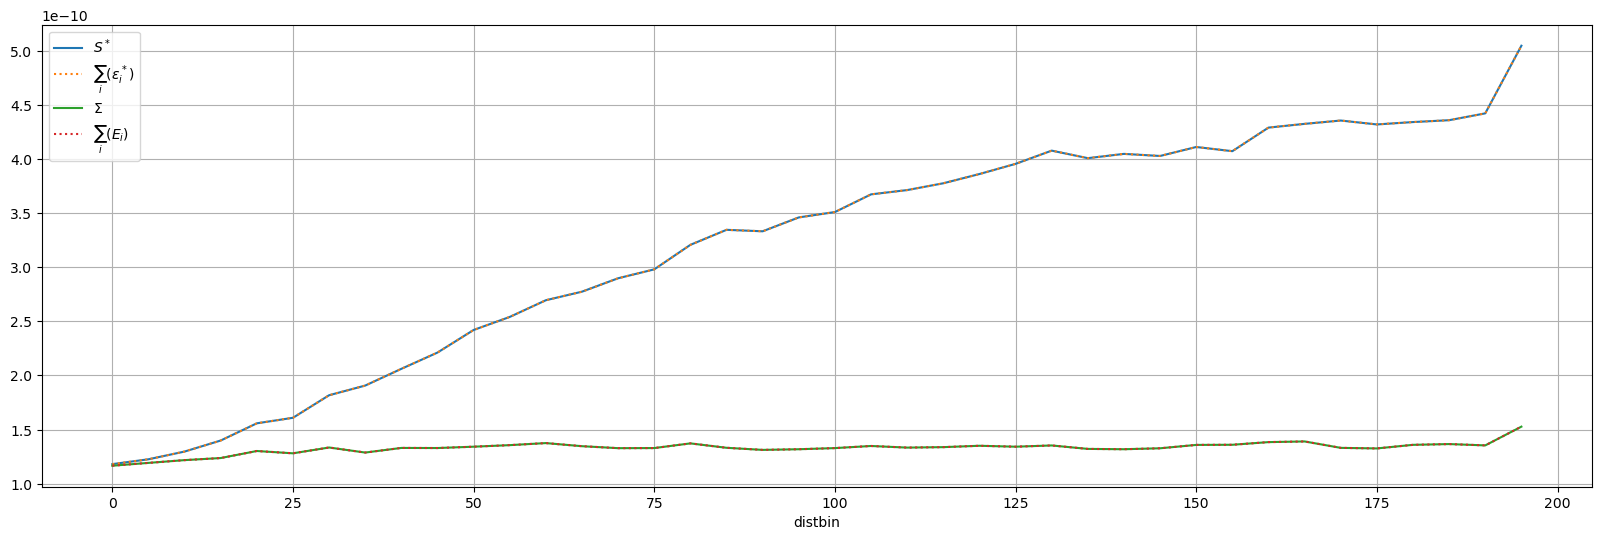

In [56]:
fig, ax= plt.subplots(1, 1,figsize=(20,6))

df2.groupby("distbin")['s'].mean().plot(label=r'$S^*$', ax=ax)
(df.groupby("distbin")['sume'].mean()).plot(label=r'$\sum_i(\epsilon^*_i)$', ax=ax, ls=':')

df2.groupby("distbin")['sd'].mean().plot(label=r'$\Sigma$', ax=ax)
(df.groupby("distbin")['sumed'].mean()).plot(label=r'$\sum_i(E_i)$', ax=ax, ls=':')
ax.grid()
ax.legend()

## Check $\beta_{i} + \epsilon_{i} = A_{i}$


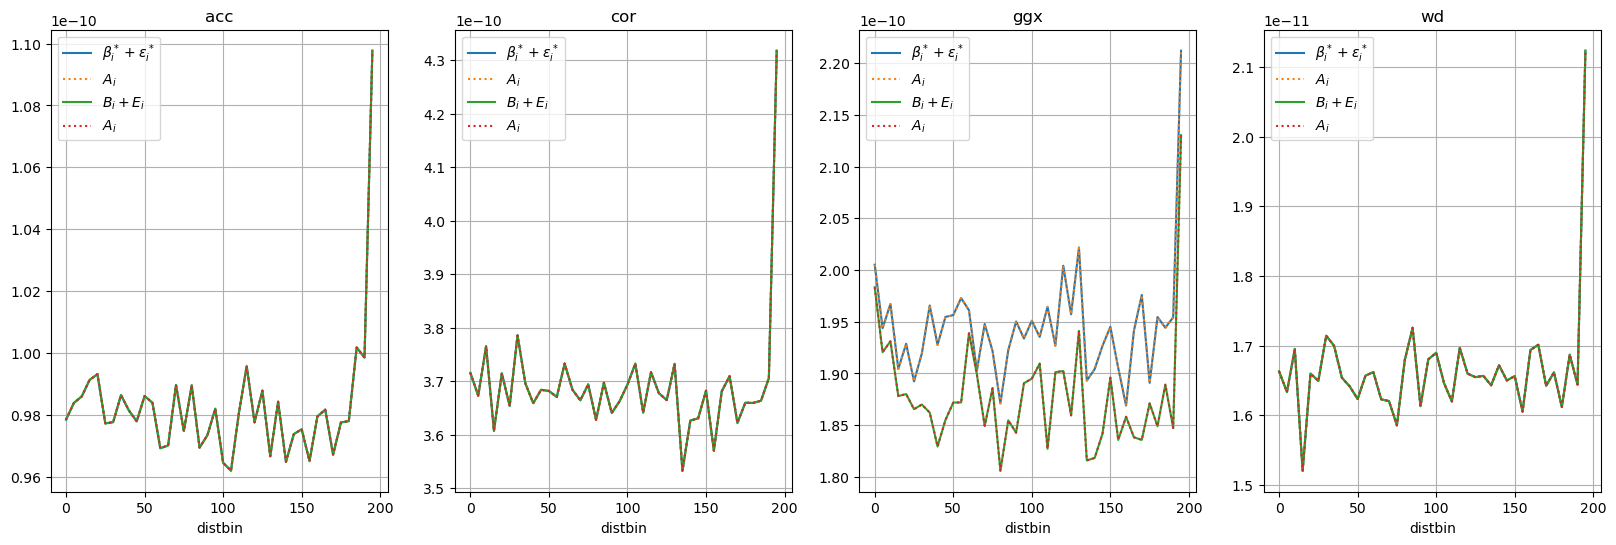

In [57]:
fig, axs = plt.subplots(1, 4,figsize=(20,6))
axs = axs.flatten()
for i in range(len(var)):
    ax = axs[i]
    v, vd = var[i], vard[i]
    (df.groupby("distbin")['b_'+v].mean()+df.groupby("distbin")[v+'s'].mean()).plot(label=r'$\beta^*_i + \epsilon^*_i$', ax=ax)
    (df2.groupby("distbin")[v].mean()).plot(label=r'$A_i$', ax=ax, ls=':')
    
    (df.groupby("distbin")['bd_'+vd].mean()+df.groupby("distbin")[vd+'sd'].mean()).plot(label=r'$B_i + E_i$', ax=ax)
    (df2.groupby("distbin")[vd].mean()).plot(label=r'$A_i$', ax=ax, ls=':')
    ax.grid()
    ax.set_title(v)
    ax.legend()

## Pairs contributions $X_{ij} = -2\langle a_i a_j \rangle$ en fonction de $X_{ijeq} = -2\langle a_i a_j \rangle$

- Pour l'équilibre sans erreur de colocalisation:
  $X_{ij} = -2\langle b_i b_j \rangle$ ne dépend pas de dl
  
- Pour l'équilibre avec erreur de colocalisation:
    - pour $i,j\neq 3$ :
      $$X^*_{ij} = X_{ij} = -2\langle b_i b_j \rangle$$
    - pour $i=3$, $j\neq 3$, par exemple j=1:
      $$X^*_{3i} = -2\langle a^*_3 a_i \rangle = -2\langle (a^*_3-a_3+a_3) a_i \rangle = -2\langle d_3 a_i \rangle + X_{3i}$$
- On remarque que $\sum X_{ij} = \sum_i B_i$

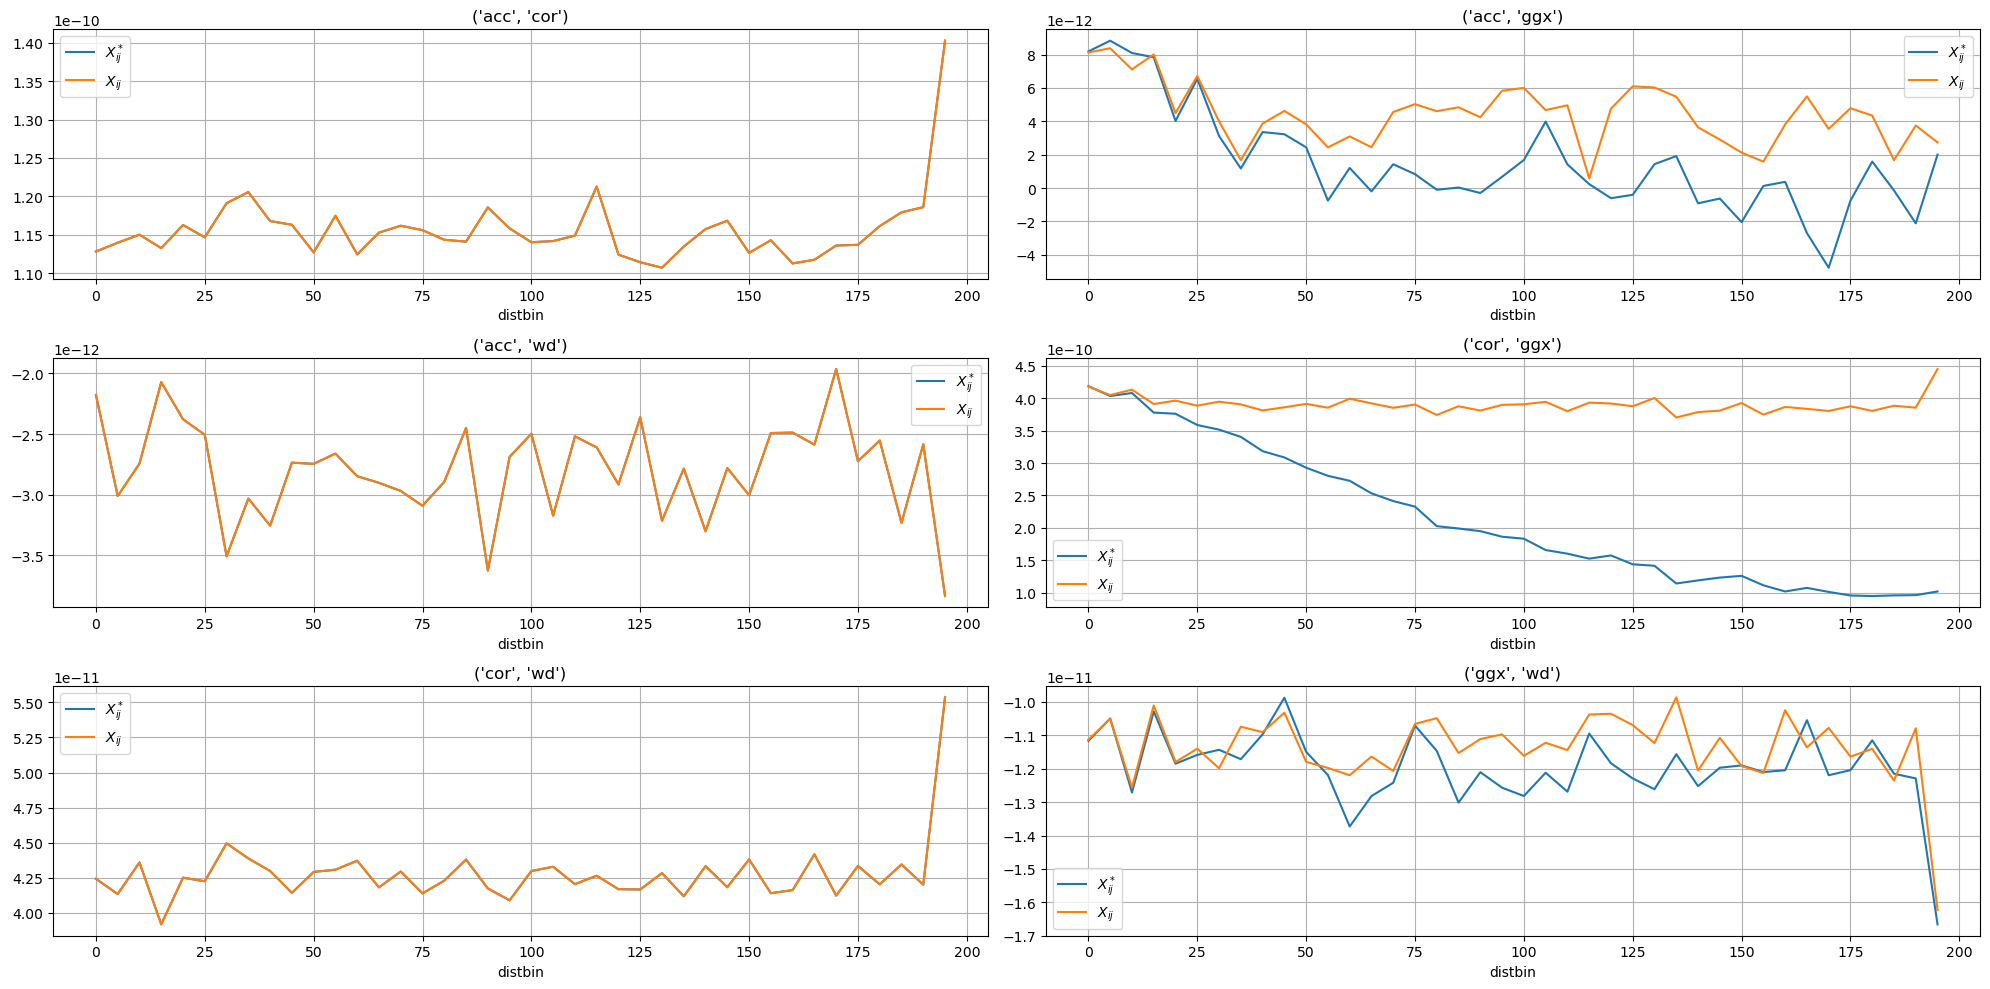

In [58]:
fig, axs = plt.subplots(3, 2,figsize=(20,10))
axs = axs.flatten()
for i in range(len(comb)):
    ax = axs[i]
    c, cd = comb[i], combd[i]
    (-2 * df.groupby("distbin")[f'{c[0]}_{c[1]}'].mean()).plot(label=r'$X^*_{ij}$', ax=ax)
    (-2*df.groupby("distbin")[f'{cd[0]}_{cd[1]}'].mean()).plot(label=r'$X_{ij}$', ax=ax)
    ax.grid()
    ax.set_title(c)
    ax.legend()
fig.tight_layout()

## A propos de $\Sigma$
$$\Sigma = \sum_i A_i = \sum_i B_i +\sum_i E_i $$ 
$\Sigma$ n'est pas impacté par l'erreur de colocalisation, et on a : $$\Sigma - \Sigma^* = A'_3-A_3$$

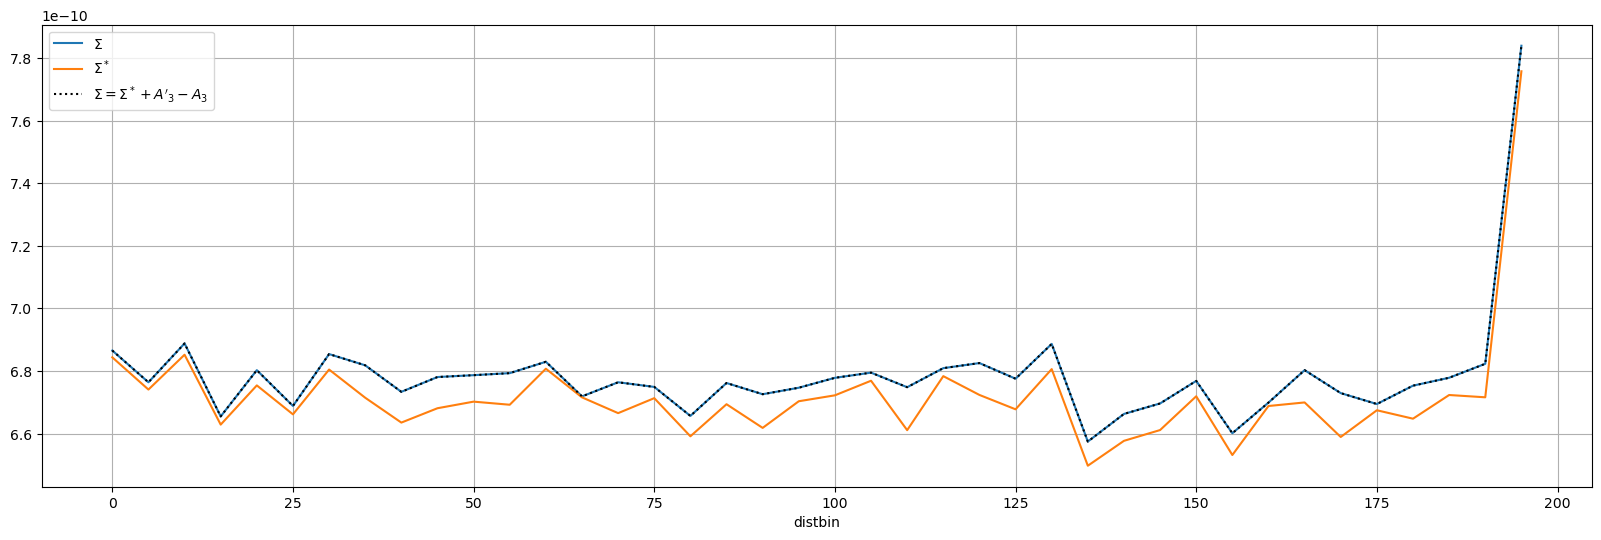

In [59]:
df2['sig'] = df2[[v for v in var]].sum(axis=1)
df2['sigd'] = df2[[v for v in vard]].sum(axis=1)
fig, ax= plt.subplots(1, 1,figsize=(20,6))
df2.groupby("distbin")['sig'].mean().plot(label=r'$\Sigma$', ax=ax)
df2.groupby("distbin")['sigd'].mean().plot(label=r'$\Sigma^*$', ax=ax)
(df2.groupby("distbin")['sigd'].mean() + df2.groupby("distbin")['ggx'].mean() - df2.groupby("distbin")['ggxd'].mean()).plot(label=r"$\Sigma = \Sigma^* + A'_3-A_3$", ax=ax, ls=':', c='k')
ax.grid()
ax.legend()

In [49]:
df['sumb'] = df[['b_'+v for v in var]].sum(axis=1)
df['sumbd'] = df[['bd_'+v for v in vard]].sum(axis=1)
df['sume'] = df[[v+'s' for v in var]].sum(axis=1)
df['sumed'] = df[[v+'sd' for v in vard]].sum(axis=1)

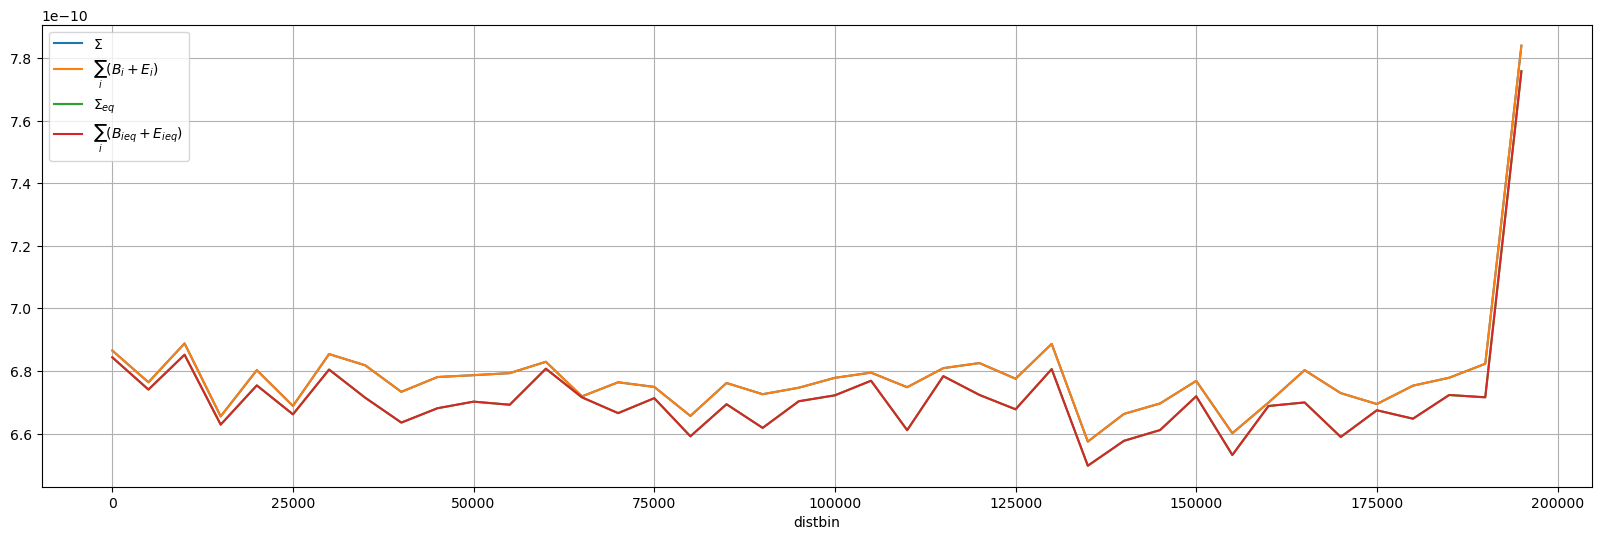

In [50]:
fig, ax= plt.subplots(1, 1,figsize=(20,6))

df2.groupby("distbin")['sig'].mean().plot(label=r'$\Sigma$', ax=ax)
(df.groupby("distbin")['sumb'].mean() + df.groupby("distbin")['sume'].mean()).plot(label=r'$\sum_i(B_i+E_i)$', ax=ax)

df2.groupby("distbin")['sigd'].mean().plot(label=r'$\Sigma^*$', ax=ax)
(df.groupby("distbin")['sumbd'].mean() + df.groupby("distbin")['sumed'].mean()).plot(label=r'$\sum_i(B_i+E_i)$', ax=ax)
ax.grid()
ax.legend()

# Différence A_3/A'_3 ??
A priori, ne devait pas avoir de grosse différences, ni de tendance, mais sur tout les DL on a globalement A'_3 < A_3, mais pourquoi ???

<Axes: >

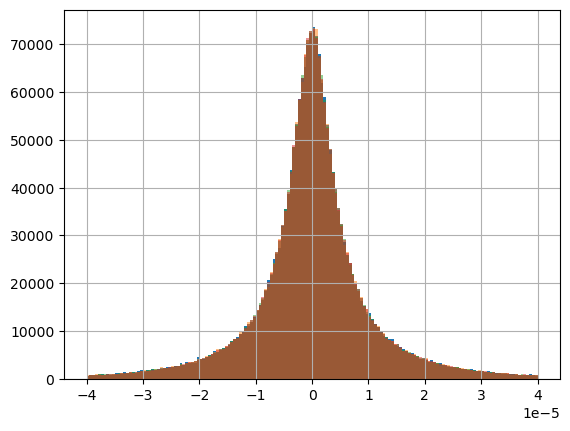

In [51]:
df_.ggx.hist(bins = np.arange(-4e-5, 4e-5, 5e-7), density=True)
df_.ggxd.hist(bins = np.arange(-4e-5, 4e-5, 5e-7), density=True, alpha = 0.5)
df.ggx.hist(bins = np.arange(-4e-5, 4e-5, 5e-7), density=True, alpha=0.5)
df.ggxd.hist(bins = np.arange(-4e-5, 4e-5, 5e-7), density=True, alpha = 0.5)

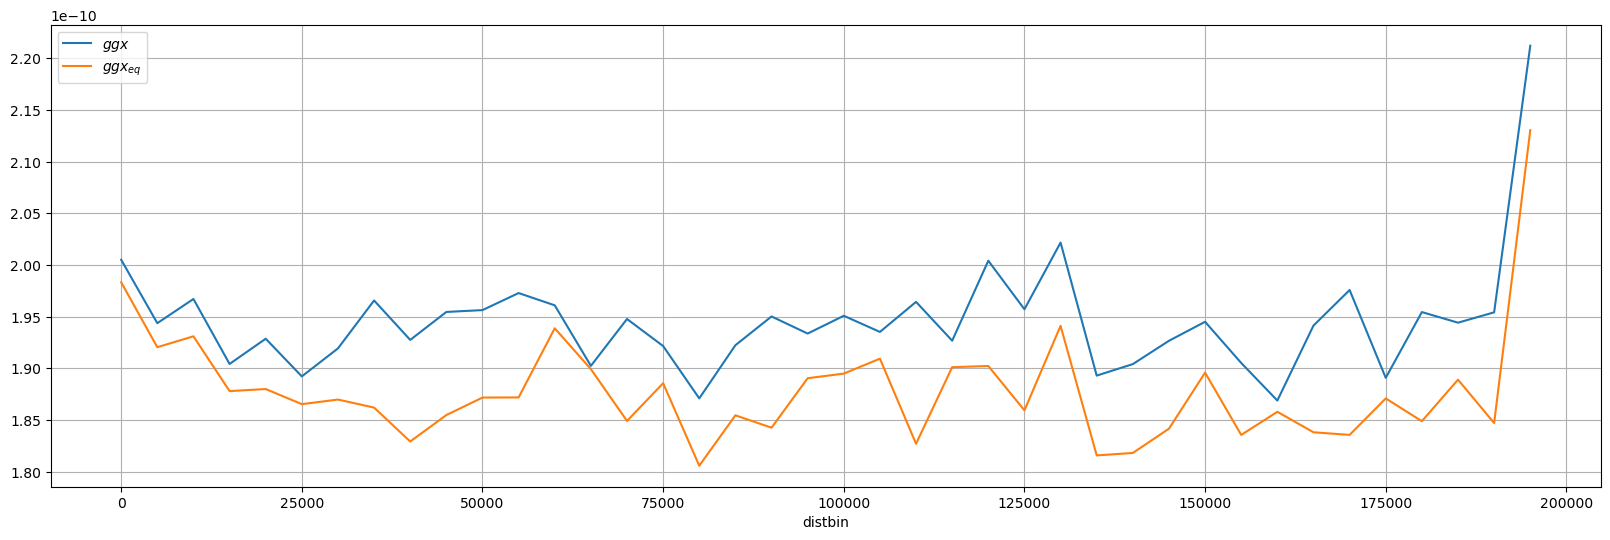

In [52]:
fig, ax= plt.subplots(1, 1,figsize=(20,6))
df2.groupby("distbin")['ggx'].mean().plot(label=r'$ggx$', ax=ax)
df2.groupby("distbin")['ggxd'].mean().plot(label=r'$ggx^*$', ax=ax)
ax.grid()
ax.legend()

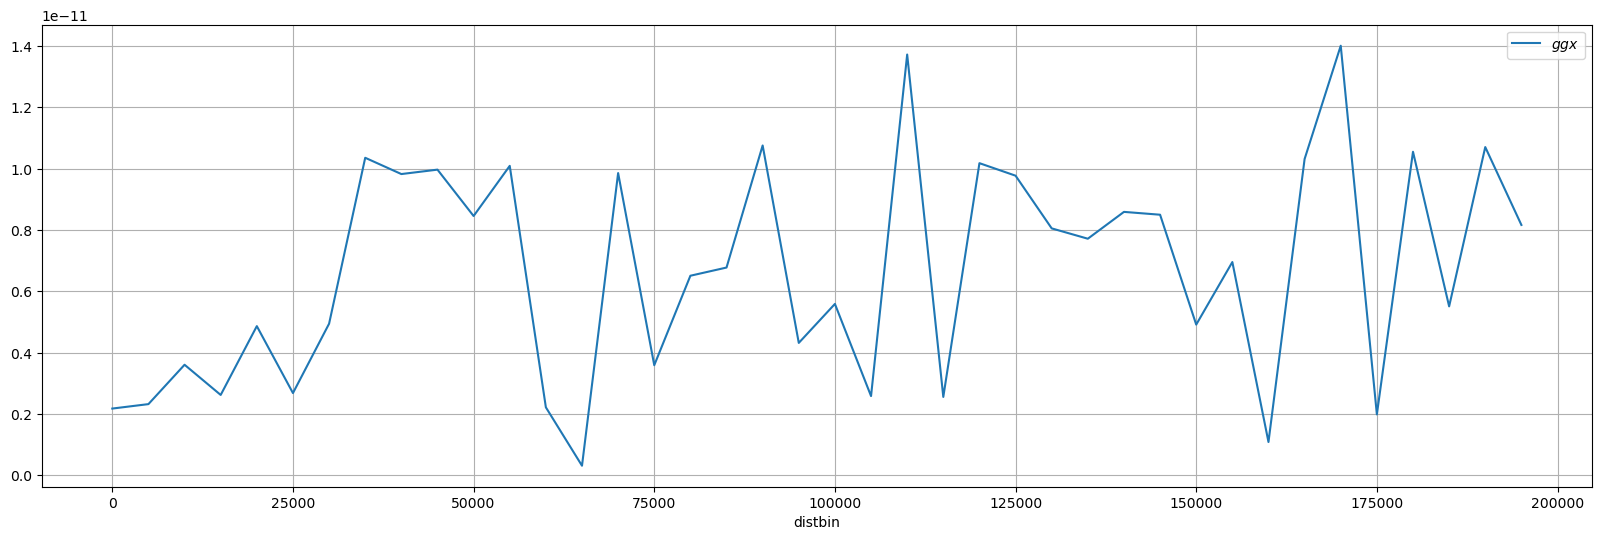

In [53]:
fig, ax= plt.subplots(1, 1,figsize=(20,6))
(df2.groupby("distbin")['ggx'].mean()-df2.groupby("distbin")['ggxd'].mean()).plot(label=r'$ggx$', ax=ax)
ax.grid()
ax.legend()

- pas facile (impossible ?) d'estimer le $\langle a_i d_3 \rangle$
- Pour le along-track, je peux connaître un $\langle d_3 \rangle$ et un $d_3$ et $A_3 - A'_3$ en fonction de DL mais seulement sur la direction de la trace ... un $\langle a'_3 d_3 \rangle$ aussi ?
- L'origine sur les courbes sans DL donne une idée

In [9]:
cluster.close()